In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import random
from datetime import timedelta
from pandas.tseries.offsets import DateOffset
from scipy.stats import percentileofscore, zscore

In [2]:
file_path = 'BTCUSDT.csv'
data = pd.read_csv(file_path)

data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

train_start = '2020-01-01 00:00:00'
train_end   = '2020-08-30 23:59:00'
test_start  = '2020-09-01 00:00:00'
test_end    = '2021-07-30 23:59:00'

train_data = data.loc[train_start:train_end]
test_data  = data.loc[test_start:test_end]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[['open']])
test_scaled  = scaler.transform(test_data[['open']])

train_torch = torch.tensor(train_scaled, dtype=torch.float32)
test_torch  = torch.tensor(test_scaled,  dtype=torch.float32)

/tmp/ipykernel_6604/4068834835.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:
def create_sequences(data_tensor, seq_length):
    sequences = []
    for i in range(len(data_tensor) - seq_length):
        seq = data_tensor[i:i + seq_length]
        sequences.append(seq)
    return torch.stack(sequences)

sequence_length = 30
test_dates = test_data.index[sequence_length:]
train_sequences = create_sequences(train_torch, sequence_length)
test_sequences  = create_sequences(test_torch, sequence_length)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_dims=[64, 32, 16]):
        super(Autoencoder, self).__init__()
        # Encoder
        encoder_layers = []
        curr_size = input_size
        for hd in hidden_dims:
            encoder_layers.append(nn.Linear(curr_size, hd))
            encoder_layers.append(nn.ReLU())
            curr_size = hd
        
        # Decoder
        decoder_layers = []
        hidden_dims.reverse()
        for hd in hidden_dims[1:]:
            decoder_layers.append(nn.Linear(curr_size, hd))
            decoder_layers.append(nn.ReLU())
            curr_size = hd
        
        decoder_layers.append(nn.Linear(curr_size, input_size))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)      #(batch_size, seq_length*features) flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), -1)  # reshape back
        return decoded

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  
        return out

In [6]:
class CNNModel(nn.Module):
    """
    CNN-based model for reconstruction-based anomaly detection.
    """
    def __init__(self, input_size, out_channels=16, kernel_size=3):
        super(CNNModel, self).__init__()
        # 1 feature, channel=1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, 
                               kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        # Flatten -> fully connected -> reshape
        self.fc = nn.Linear(out_channels * input_size, input_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, 1) 
        x = x.transpose(1, 2)   # shape: (batch_size, 1, seq_len)
        x = self.conv1(x)       # (batch_size, out_channels, seq_len)
        x = self.relu(x)
        x = x.reshape(x.size(0), -1)  # flatten to (batch_size, out_channels * seq_len)
        x = self.fc(x)             # (batch_size, input_size)
        return x.unsqueeze(-1)     # (batch_size, input_size, 1)


In [7]:
class StackVAEG(nn.Module):
    def __init__(self, input_size, hidden_dims=[64, 32], latent_dim=16):
        super(StackVAEG, self).__init__()
        self.input_size = input_size
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Encoder
        encoder_layers = []
        in_dim = self.input_size
        for hdim in self.hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, hdim))
            encoder_layers.append(nn.ReLU())
            in_dim = hdim
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(in_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(in_dim, self.latent_dim)
        
        # Decoder
        decoder_layers = []
        out_dim = self.hidden_dims[-1]
        decoder_layers.append(nn.Linear(self.latent_dim, out_dim))
        decoder_layers.append(nn.ReLU())
        for hdim in reversed(self.hidden_dims[:-1]):
            decoder_layers.append(nn.Linear(out_dim, hdim))
            decoder_layers.append(nn.ReLU())
            out_dim = hdim
        decoder_layers.append(nn.Linear(out_dim, self.input_size))
        
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        # Flatten
        x = x.view(x.size(0), -1)
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        
        return reconstructed.view(x.size(0), -1), mu, logvar

In [8]:
class OmniAnomaly(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, latent_dim=16, num_layers=1):
        super(OmniAnomaly, self).__init__()
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        # LSTM Encoder
        self.lstm_enc = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)
        
        # LSTM Decoder
        self.lstm_dec = nn.LSTM(latent_dim, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        enc_out, _ = self.lstm_enc(x)  
        mu = self.fc_mu(enc_out)       # (batch_size, seq_len, latent_dim)
        logvar = self.fc_logvar(enc_out)
        
        z = self.reparameterize(mu, logvar)  # (batch_size, seq_len, latent_dim)
        
        dec_out, _ = self.lstm_dec(z)
        reconstructed = self.fc_out(dec_out)  # (batch_size, seq_len, input_size)
        
        return reconstructed, mu, logvar

In [9]:
class EGADSModel:
    def __init__(self, window=30):
        self.window = window
        self.train_length_ = None

    def fit(self, data):
        data = data.flatten()
        self.train_length_ = len(data)
        
    def predict(self, data):
        data = data.flatten()
        full_series = pd.Series(data)
        
        roll_mean = full_series.rolling(self.window, min_periods=1).mean()
        roll_std = full_series.rolling(self.window, min_periods=1).std()

        roll_std = roll_std.fillna(1e-8)

        z_scores = np.abs(data - roll_mean) / roll_std
        
        anomaly_scores = z_scores.to_numpy()  
        return anomaly_scores

In [10]:
class DTWModel:
    def __init__(self, window=30, n_references=10, seed=42):
        self.window = window
        self.n_references = n_references
        self.references = []
        self.seed = seed
    
    def fit(self, train_sequences):
        np.random.seed(self.seed)
        total_sequences = train_sequences.shape[0]
        selected_indices = np.random.choice(total_sequences, self.n_references, replace=False)
        self.references = [train_sequences[i].squeeze().numpy() for i in selected_indices]
        print(f"DTWModel: Selected {self.n_references} reference sequences.")
    
    def predict(self, test_sequences):
        scores = []
        for seq in test_sequences:
            seq_np = seq.squeeze().numpy()
            distances = [dtw.distance(seq_np, ref) for ref in self.references]
            min_distance = min(distances)
            scores.append(min_distance)
        return np.array(scores)

In [11]:
class AnomalyDetector:
    def __init__(self, model_name, model_params, sequence_length=30, device='cpu'):
        self.model_name = model_name.lower()
        self.model_params = model_params
        self.sequence_length = sequence_length
        self.device = device
        
        if self.model_name == 'egads':
            self.model = EGADSModel(**self.model_params)
        elif self.model_name == 'dtw':
            self.model = DTWModel(**self.model_params)
        else:
            self.model = self._initialize_model().to(self.device)
        
    def _initialize_model(self):
        if self.model_name == 'autoencoder':
            return Autoencoder(**self.model_params)
        elif self.model_name == 'lstm':
            return LSTMModel(**self.model_params)
        elif self.model_name == 'cnn':
            return CNNModel(**self.model_params)
        elif self.model_name == 'stackvaeg':
            return StackVAEG(**self.model_params)
        elif self.model_name == 'omnianomaly':
            return OmniAnomaly(**self.model_params)
        else:
            raise ValueError(f"Unknown model_name: {self.model_name}")
    
    def train(self, train_sequences=None, num_epochs=10, batch_size=32, learning_rate=1e-3, train_raw=None):
        if self.model_name == 'egads':
            if train_raw is None:
                raise ValueError("EGADS requires 'train_raw'")
            data_np = train_raw.cpu().numpy().flatten()
            self.model.fit(data_np)
            return
        elif self.model_name == 'dtw':
            if train_sequences is None:
                raise ValueError("DTW requires 'train_sequences'")
            self.model.fit(train_sequences)
            return
        
        if train_sequences is None:
            raise ValueError(f"{self.model_name} requires 'train_sequences'")
        
        train_loader = torch.utils.data.DataLoader(train_sequences, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        self.model.train()
        for epoch in tqdm(range(num_epochs), desc=f"Training {self.model_name}"):
            running_loss = 0.0
            for batch in train_loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()
                
                if self.model_name in ['stackvaeg', 'omnianomaly']:
                    if self.model_name == 'stackvaeg':
                        outputs, mu, logvar = self.model(batch)
                        batch_flat = batch.view(batch.size(0), -1)
                        recon_loss = nn.MSELoss()(outputs, batch_flat)
                    else:  
                        reconstructed, mu, logvar = self.model(batch)
                        recon_loss = nn.MSELoss()(reconstructed, batch)
                    # KLD
                    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = recon_loss + kld * 0.001
                else:
                    outputs = self.model(batch)
                    if self.model_name == 'cnn':
                        loss = nn.MSELoss()(outputs, batch.view_as(outputs))
                    elif self.model_name == 'lstm':
                        loss = nn.MSELoss()(outputs, batch)
                    else:
                        loss = nn.MSELoss()(outputs, batch.view(outputs.size()))
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

    def predict(self, test_sequences=None, test_raw=None):
        if self.model_name == 'egads':
            if test_raw is None:
                raise ValueError("EGADS requires 'test_raw'")
            scores = self.model.predict(test_raw.cpu().numpy().flatten())
            return scores
        elif self.model_name == 'dtw':
            if test_sequences is None:
                raise ValueError("DTW requires 'test_sequences'")
            scores = self.model.predict(test_sequences)
            return scores
        
        self.model.eval()
        all_errors = []
        with torch.no_grad():
            for i in range(len(test_sequences)):
                x = test_sequences[i].unsqueeze(0).to(self.device)
                if self.model_name in ['stackvaeg', 'omnianomaly']:
                    if self.model_name == 'stackvaeg':
                        outputs, _, _ = self.model(x)
                        target = x.view(1, -1)
                        mse = torch.mean((outputs - target) ** 2, dim=1)
                    else:
                        reconstructed, _, _ = self.model(x)
                        mse = torch.mean((reconstructed - x) ** 2, dim=[1,2])
                else:
                    outputs = self.model(x)
                    if self.model_name == 'cnn':
                        mse = torch.mean((outputs - x.view_as(outputs)) ** 2, dim=[1,2])
                    elif self.model_name == 'lstm':
                        mse = torch.mean((outputs - x) ** 2, dim=[1,2])
                    else:
                        # autoencoder
                        mse = torch.mean((outputs - x.view(1, -1)) ** 2, dim=1)
                all_errors.append(mse.item())
        return np.array(all_errors)
    
    def get_anomalies(self, errors, percentile=99.5):
        threshold = np.percentile(errors, percentile)
        anomalies = errors > threshold
        return anomalies, threshold


In [40]:
def detect_anomalies(mse, num_std):
    """Detect anomalies in test data using thresholding."""
    threshold = np.mean(mse) + num_std*np.std(mse)
    #print("Threshold = ", np.round(threshold, 2))
    anomalies = np.where(mse > np.round(threshold, 2))[0]
    return anomalies

def deviation_from_mean(data, value):
    z_scores = zscore(data)
    
    deviation = (value - np.mean(data)) / np.std(data)
    return deviation

def simulate_trading_std(
    model_name,
    price_data,
    ma_data,
    scores,
    rolling_stds, 
    rolling_anomalies,    
    num_std,
    max_entries,
):
    step = 1/(2 * max_entries)
    
    initial_capital = 1.0
    capital = initial_capital
    capital_history = pd.Series(index=price_data.index, data=np.nan)
    capital_history.iloc[0] = capital

    open_trades = []
    trade_entries = set()  # Timestamps where trades are opened

    index_array = list(price_data.index) 

    for i in range(len(index_array)):
        timestamp = index_array[i]

        current_price = price_data.iloc[i]
        current_ma    = ma_data.iloc[i]
        trades_to_close = []
        for trade in open_trades:
            trade_type = trade["type"]
            entry_price = trade["entry_price"]
            entry_time = trade["entry_time"] 
            anomaly_deviation = trade["anomaly_deviation"]  
            if trade_type == "buy" and current_price >= current_ma:
                exit_price = current_price
                profit = (exit_price - entry_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_deviation:.2f}%, P&L: {profit:.4f}"
                )

            elif trade_type == "sell" and current_price <= current_ma:
                exit_price = current_price
                profit = (entry_price - exit_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_deviation:.2f}%, P&L: {profit:.4f}"
                )

        for closed_trade in trades_to_close:
            open_trades.remove(closed_trade)

        if rolling_anomalies[i] and len(open_trades) < max_entries:
            k = len(open_trades)  
            required_threshold = num_std + k * step 

            anomaly_deviation = rolling_stds[i]  
            if anomaly_deviation >= required_threshold: 
                if timestamp not in trade_entries:
                    trade_entries.add(timestamp)
                    if current_price > current_ma:
                        trade_type = "sell"
                    elif current_price < current_ma:
                        trade_type = "buy"
                    else:
                        trade_type = None

                    if trade_type is not None:
                        trade_volume = capital / max_entries
                        open_trades.append({
                            "type": trade_type,
                            "volume": trade_volume,
                            "entry_price": current_price,
                            "entry_time": timestamp,
                            "anomaly_deviation": anomaly_deviation  
                        })


        capital_history.iloc[i] = capital

    capital_history.ffill(inplace=True)
    capital_history.fillna(capital, inplace=True)

    return capital_history

In [44]:
def simulate_trading_percentile(
    model_name,
    price_data,
    ma_data,
    scores,
    rolling_percentiles, 
    rolling_anomalies,    
    percentile,
    max_entries,
):

    initial_capital = 1.0
    capital = initial_capital
    capital_history = pd.Series(index=price_data.index, data=np.nan)
    capital_history.iloc[0] = capital

    open_trades = []
    trade_entries = set()  # Timestamps where trades are opened

    index_array = list(price_data.index) 

    for i in range(len(index_array)):
        timestamp = index_array[i]

        current_price = price_data.iloc[i]
        current_ma    = ma_data.iloc[i]
        trades_to_close = []
        for trade in open_trades:
            trade_type = trade["type"]
            entry_price = trade["entry_price"]
            entry_time = trade["entry_time"] 
            anomaly_percentage = trade["anomaly_percentage"]  
            if trade_type == "buy" and current_price >= current_ma:
                exit_price = current_price
                profit = (exit_price - entry_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_percentage:.2f}%, P&L: {profit:.4f}"
                )

            elif trade_type == "sell" and current_price <= current_ma:
                exit_price = current_price
                profit = (entry_price - exit_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_percentage:.2f}%, P&L: {profit:.4f}"
                )

        for closed_trade in trades_to_close:
            open_trades.remove(closed_trade)

        if rolling_anomalies[i] and len(open_trades) < max_entries:
            k = len(open_trades)  
            required_threshold = percentile + k * step 
            if required_threshold >= 100.0:
                required_threshold = 100.1

            anomaly_percentile = rolling_percentiles[i]  
            if anomaly_percentile >= required_threshold: 
                if timestamp not in trade_entries:
                    trade_entries.add(timestamp)
                    if current_price > current_ma:
                        trade_type = "sell"
                    elif current_price < current_ma:
                        trade_type = "buy"
                    else:
                        trade_type = None

                    if trade_type is not None:
                        trade_volume = capital / max_entries
                        anomaly_percentage = 100.0 - anomaly_percentile  
                        open_trades.append({
                            "type": trade_type,
                            "volume": trade_volume,
                            "entry_price": current_price,
                            "entry_time": timestamp,
                            "anomaly_percentage": anomaly_percentage  
                        })


        capital_history.iloc[i] = capital

    capital_history.ffill(inplace=True)
    capital_history.fillna(capital, inplace=True)

    return capital_history


In [54]:
#window_days = 55
window_minutes = 5000 #for rolling mean
percentile = 99.5
max_entries = 1
step = (100 - percentile) / max_entries

mode = 'percentile' #'std'/'percentile'
num_std = 3

window_size_minutes = 10000 #window for final anomalies distribution

original_data_sorted = data[['open', 'close']].copy().sort_index()

original_data_sorted['rolling_avg'] = original_data_sorted['open'].rolling(window=window_minutes).mean()
original_data_sorted['rolling_low'] = original_data_sorted['open'].rolling(window=window_minutes).min()
original_data_sorted['rolling_high'] = original_data_sorted['open'].rolling(window=window_minutes).max()


def analyze_anomalies(anomaly_timestamps, original_data_sorted, window_minutes=13*24*60):
    results = []
    
    for ts in anomaly_timestamps:
        if ts < original_data_sorted.index[window_minutes-1]:
            continue
        
        future_time = ts + pd.Timedelta(hours=1)
        if future_time > original_data_sorted.index[-1]:
            continue
        
        try:
            open_price = original_data_sorted.loc[ts, 'open']
        except KeyError:
            continue
        
        prev_time = ts - pd.Timedelta(minutes=1)
        if prev_time not in original_data_sorted.index:
            continue
        rolling_avg = original_data_sorted.loc[prev_time, 'rolling_avg']
        rolling_low = original_data_sorted.loc[prev_time, 'rolling_low']
        rolling_high = original_data_sorted.loc[prev_time, 'rolling_high']
        
        if np.isnan(rolling_avg) or np.isnan(rolling_low) or np.isnan(rolling_high):
            continue
        
        above_avg = open_price > rolling_avg
        
        above_low = open_price > rolling_low
        below_high = open_price < rolling_high
        
        try:
            next_hour_data = original_data_sorted.loc[ts + pd.Timedelta(minutes=1): ts + pd.Timedelta(hours=1)]
        except KeyError:
            continue
        
        if next_hour_data.empty:
            continue
        
        min_open_next_hour = next_hour_data['open'].min()
        max_open_next_hour = next_hour_data['open'].max()
        
        try:
            close_price_next_hour = original_data_sorted.loc[ts + pd.Timedelta(hours=1), 'close']
        except KeyError:
            continue
        
        if above_avg:
            price_after = min_open_next_hour
            price_change = min_open_next_hour - open_price
            direction = 'Min'
        else:
            price_after = max_open_next_hour
            price_change = max_open_next_hour - open_price
            direction = 'Max'
        
        close_change = close_price_next_hour - open_price
        
        price_change_pct = (price_change / open_price) * 100
        close_change_pct = (close_change / open_price) * 100
        
        if above_avg:
            if price_after < open_price:
                sign = 1  
            elif price_after > open_price:
                sign = -1  
            else:
                sign = 0
        else:
            if price_after > open_price:
                sign = 1  
            elif price_after < open_price:
                sign = -1  
            else:
                sign = 0
        
        price_change_pct_signed = price_change_pct * sign
        close_change_pct_signed = close_change_pct * sign
        
        relative_to_avg = 'Above Avg' if above_avg else 'Below Avg'
        relative_to_low_high = []
        if above_low:
            relative_to_low_high.append('Above Low')
        if below_high:
            relative_to_low_high.append('Below High')
        if not relative_to_low_high:
            relative_to_low_high.append('At Low/High')  
        
        results.append({
            'timestamp': ts,
            'open_price': open_price,
            'rolling_avg': rolling_avg,
            'rolling_low': rolling_low,
            'rolling_high': rolling_high,
            'relative_to_avg': relative_to_avg,
            'relative_to_low_high': ', '.join(relative_to_low_high),
            'price_after': price_after,
            'price_change_pct_signed': price_change_pct_signed,
            'direction': direction,
            'close_next_hour': close_price_next_hour,
            'close_change_pct_signed': close_change_pct_signed
        })
    
    results_df = pd.DataFrame(results)
    return results_df

def compute_statistics(results_df, model_name):
    if results_df.empty:
        print("No anomalies to analyze.")
        return
    
    print(f"\n=== Statistics for {model_name.capitalize()} ===")
    
    relative_to_avg = results_df['relative_to_avg']
    print(f"\nRelative to {window_minutes}-minutes Average:")
    print(relative_to_avg.value_counts())
    
    relative_to_low_high = results_df['relative_to_low_high']
    print(f"\nRelative to {window_minutes}-minutes Low/High:")
    print(relative_to_low_high.value_counts())
    
    print("\nNext Hour Min/Max Open Price Change (%):")
    print(results_df['price_change_pct_signed'].describe())
    
    print("\nNext Hour Close Price Change (%):")
    print(results_df['close_change_pct_signed'].describe())
    
    plt.figure(figsize=(10, 5))
    relative_to_avg.value_counts().plot(kind='bar')
    plt.title(f'{model_name.capitalize()} - Relative to {window_minutes}-minutes Average')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    relative_to_low_high.value_counts().plot(kind='bar')
    plt.title(f'{model_name.capitalize()} - Relative to {window_minutes}-minutes Low/High')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    results_df['price_change_pct_signed'].hist(bins=30)
    plt.title(f'{model_name.capitalize()} - Next Hour Min/Max Open Price Change (%) Distribution')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    results_df['close_change_pct_signed'].hist(bins=30)
    plt.title(f'{model_name.capitalize()} - Next Hour Close Price Change (%) Distribution')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.show()

In [14]:
#model_names = ['autoencoder', 'lstm', 'cnn', 'stackvaeg', 'omnianomaly', 'egads'] ######
model_names = ['autoencoder']
model_params = {
    'autoencoder': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32, 16]
    },
    'lstm': {
        'input_size': 1,     
        'hidden_size': 32,
        'num_layers': 1
    },
    'cnn': {
        'input_size': sequence_length,
        'out_channels': 16,
        'kernel_size': 3
    },
    'stackvaeg': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32],
        'latent_dim': 16
    },
    'omnianomaly': {
        'input_size': 1,     
        'hidden_size': 32,
        'latent_dim': 16,
        'num_layers': 1
    },
    'egads': {
        'window': 30
    },
    'dtw': {
        'window': 30,
        'n_references': 10,
        'seed': 42
    }
}

In [15]:
train_initial_length = pd.DateOffset(months=6)  
train_expand_step = pd.DateOffset(months=3)    
test_length = pd.DateOffset(months=3)           

start_date = pd.Timestamp('2020-01-01 00:00:00')
end_date = pd.Timestamp('2021-12-31 23:59:00')

combined_test_dates = []      
combined_scores = {}          
combined_anomalies = {}  
original_prices_buffer = []

for model_name in model_names:
    combined_scores[model_name] = []
    combined_anomalies[model_name] = []

current_train_start = start_date
current_train_end = current_train_start + train_initial_length
current_test_start = current_train_end
current_test_end = current_test_start + test_length

In [21]:
while current_test_end <= end_date or current_test_start < end_date:
    if current_test_end > end_date:
        current_test_end = end_date
    print(f"\n=== Processing Window: Train {current_train_start} to {current_train_end}, "
          f"Test {current_test_start} to {current_test_end} ===")
    
    train_data = data.loc[current_train_start:current_train_end]
    test_data = data.loc[current_test_start:current_test_end]

    if test_data.empty:
        break
        
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data[['open']])
    test_scaled = scaler.transform(test_data[['open']])

    original_prices_buffer.extend(test_data['open'].values[sequence_length:])
    
    train_torch = torch.tensor(train_scaled, dtype=torch.float32)
    test_torch = torch.tensor(test_scaled, dtype=torch.float32)


    train_sequences = create_sequences(train_torch, sequence_length)
    test_sequences = create_sequences(test_torch, sequence_length)
    test_dates = test_data.index[sequence_length:]
    combined_test_dates.extend(test_dates)
    
    for model_name in model_names:
        print(f"\n=== Processing Model: {model_name} ===")
        
        params = model_params[model_name]
        detector = AnomalyDetector(
            model_name=model_name,
            model_params=params,
            sequence_length=sequence_length,
            device='cpu' 
        )
        
        if model_name not in ['egads', 'dtw']:
            detector.train(
                train_sequences=train_sequences,
                num_epochs=10,
                batch_size=32,
                learning_rate=1e-3
            )
        elif model_name == 'egads':
            detector.train(
                train_sequences=None,
                train_raw=train_torch
            )
        elif model_name == 'dtw':
            detector.train(
                train_sequences=train_sequences,
                num_epochs=0,
                batch_size=0,
                learning_rate=0,
                train_raw=None
            )
        
        if model_name not in ['egads', 'dtw']:
            scores = detector.predict(test_sequences=test_sequences)
        elif model_name == 'egads':
            scores = detector.predict(test_raw=test_torch)[sequence_length:]
        elif model_name == 'dtw':
            scores = detector.predict(test_sequences=test_sequences)
        
        combined_scores[model_name].extend(scores)
    
    current_train_end += train_expand_step
    current_test_start += train_expand_step
    current_test_end = current_test_start + test_length




=== Processing Window: Train 2020-01-01 00:00:00 to 2020-07-01 00:00:00, Test 2020-07-01 00:00:00 to 2020-10-01 00:00:00 ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2020-10-01 00:00:00, Test 2020-10-01 00:00:00 to 2021-01-01 00:00:00 ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-01-01 00:00:00, Test 2021-01-01 00:00:00 to 2021-04-01 00:00:00 ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-04-01 00:00:00, Test 2021-04-01 00:00:00 to 2021-07-01 00:00:00 ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-07-01 00:00:00, Test 2021-07-01 00:00:00 to 2021-10-01 00:00:00 ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-10-01 00:00:00, Test 2021-10-01 00:00:00 to 2021-12-31 23:59:00 ===


In [17]:
import numpy as np

for model_name, scores in combined_scores.items():
    scores_array = np.array(scores)
    
    np.save(f"{model_name}_combined_scores_3m.npy", scores_array)
    print(f"Saved combined_scores for {model_name} to {model_name}_combined_scores.npy")



Saved combined_scores for autoencoder to autoencoder_combined_scores.npy


In [22]:
combined_scores['autoencoder'] = np.load("autoencoder_combined_scores_3m.npy")


=== Final Outputs for Model: autoencoder ===
Found 4942 anomalies using rolling percentile = 99.5


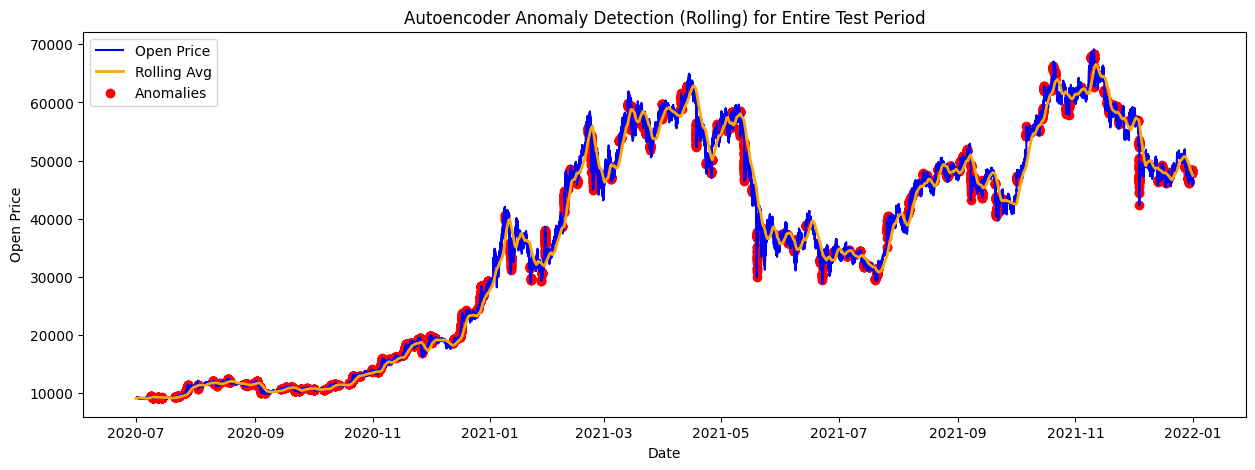


=== Statistics for Autoencoder ===

Relative to 5000-minutes Average:
relative_to_avg
Above Avg    2984
Below Avg    1933
Name: count, dtype: int64

Relative to 5000-minutes Low/High:
relative_to_low_high
Above Low, Below High    4565
Above Low                 257
Below High                 95
Name: count, dtype: int64

Next Hour Min/Max Open Price Change (%):
count    4917.000000
mean        0.015575
std         1.594024
min        -6.716179
25%        -0.544215
50%        -0.124521
75%         0.517318
max        12.396175
Name: price_change_pct_signed, dtype: float64

Next Hour Close Price Change (%):
count    4917.000000
mean        0.125957
std         1.496208
min        -9.331458
25%        -0.482456
50%         0.099954
75%         0.715534
max        12.671695
Name: close_change_pct_signed, dtype: float64


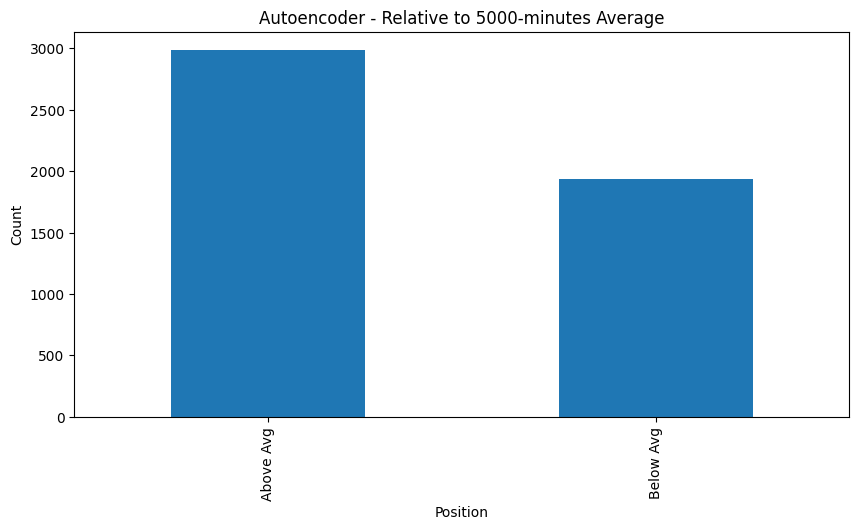

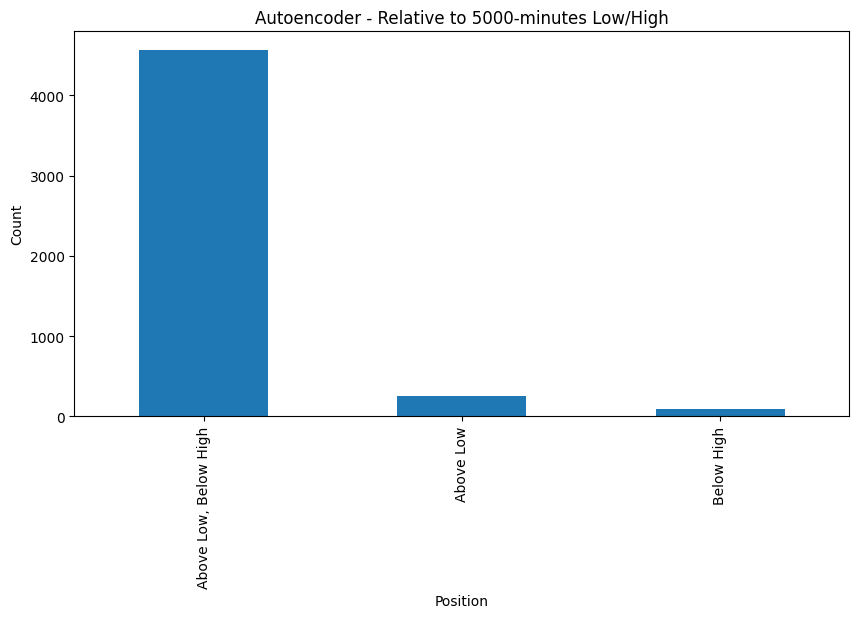

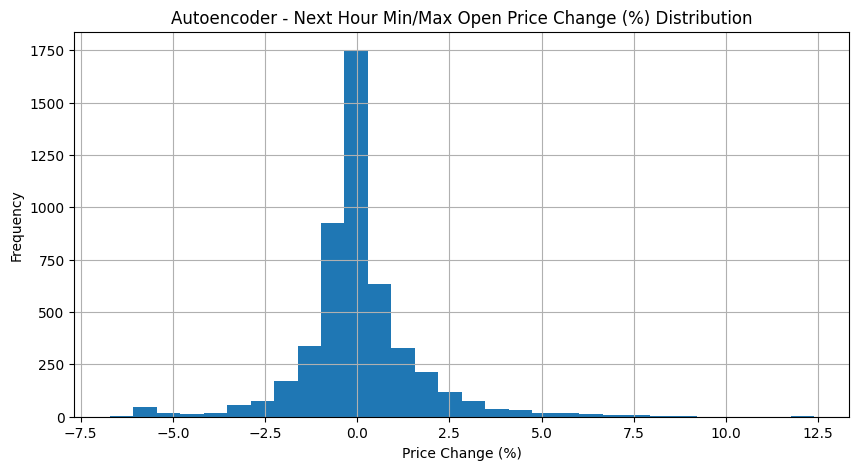

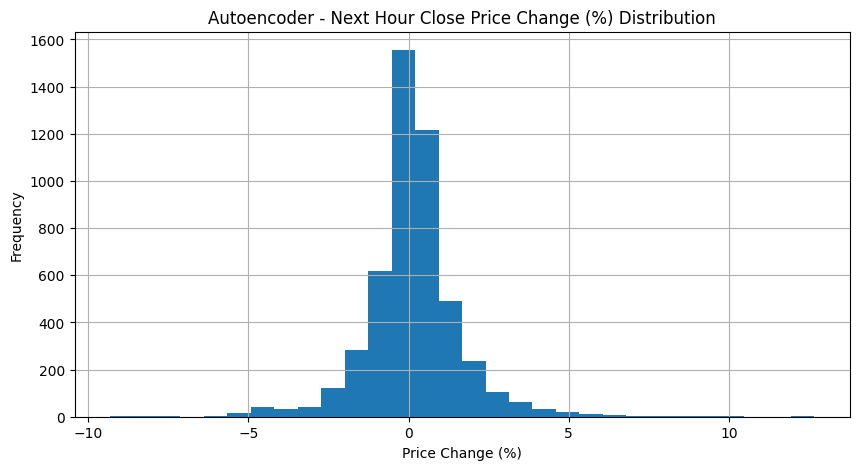

Trade executed: sell at 2020-07-08 14:06:00 (Entry Price: 9436.99), exited at 2020-07-09 14:56:00 (Exit Price: 9284.57), Volume: 1.0000, Anomaly: 0.50%, P&L: 0.0162
Trade executed: buy at 2020-07-09 15:22:00 (Entry Price: 9211.87), exited at 2020-07-10 23:33:00 (Exit Price: 9308.71), Volume: 1.0162, Anomaly: 0.27%, P&L: 0.0107
Trade executed: buy at 2020-07-12 13:28:00 (Entry Price: 9236.02), exited at 2020-07-12 21:42:00 (Exit Price: 9237.97), Volume: 1.0268, Anomaly: 0.08%, P&L: 0.0002
Trade executed: buy at 2020-07-14 11:32:00 (Entry Price: 9218.28), exited at 2020-07-14 17:47:00 (Exit Price: 9246.30), Volume: 1.0271, Anomaly: 0.50%, P&L: 0.0031
Trade executed: sell at 2020-07-21 07:47:00 (Entry Price: 9320.00), exited at 2020-07-30 13:06:00 (Exit Price: 10879.51), Volume: 1.0302, Anomaly: 0.49%, P&L: -0.1724
Trade executed: sell at 2020-08-02 04:40:00 (Entry Price: 11347.59), exited at 2020-08-02 04:41:00 (Exit Price: 10890.00), Volume: 0.8578, Anomaly: 0.00%, P&L: 0.0346
Trade exe

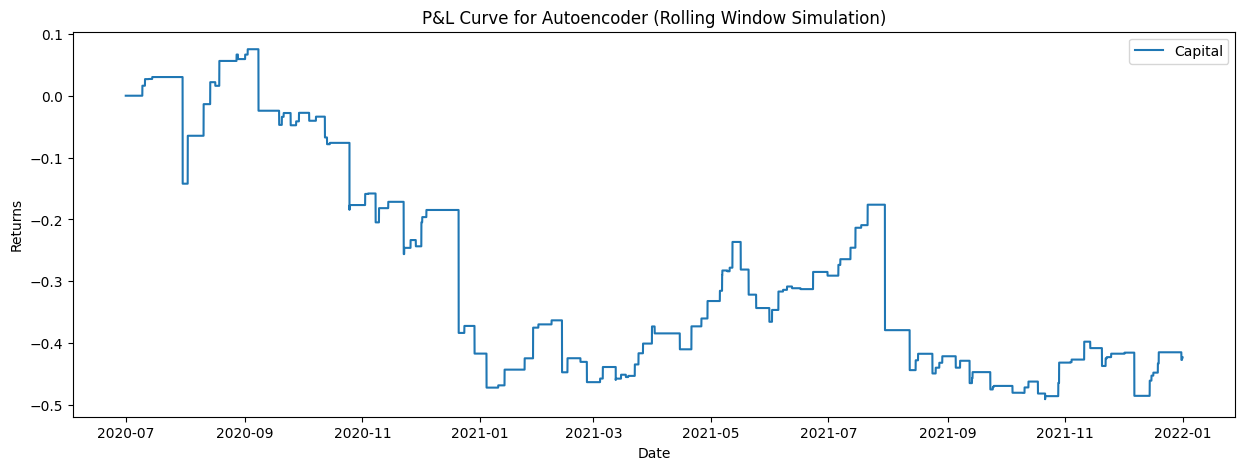

Final Capital for autoencoder: 0.5769


In [55]:
for model_name in model_names:
    print(f"\n=== Final Outputs for Model: {model_name} ===")

    combined_scores[model_name] = np.array(combined_scores[model_name])
    scores = np.array(combined_scores[model_name])

    rolling_percentiles = np.zeros_like(scores, dtype=float) 
    rolling_anomalies   = np.zeros_like(scores, dtype=bool)  
    rolling_stds = np.zeros_like(scores, dtype=float) 

    for i in range(window_size_minutes, len(scores)):
        start_idx = i - window_size_minutes
        end_idx = i  
        window_slice = scores[start_idx:end_idx]  

        current_score = scores[i]

        if mode == 'percentile':
            rank = percentileofscore(window_slice, current_score, kind='rank')
            rolling_percentiles[i] = rank  
    
            if rank >= percentile:
                rolling_anomalies[i] = True
        elif mode == 'std':
            deviation = deviation_from_mean (window_slice, current_score)
            rolling_stds[i] = deviation  
    
            if deviation >= num_std:
                rolling_anomalies[i] = True
        else:
            raise ValueError("Mode should be 'std' of 'percentile'")
            

    anomaly_dates = np.array(combined_test_dates)[rolling_anomalies]
    print(f"Found {rolling_anomalies.sum()} anomalies using rolling percentile = {percentile}")

    plt.figure(figsize=(15, 5))
    unscaled_prices = np.array(original_prices_buffer)
    plt.plot(combined_test_dates, unscaled_prices, label='Open Price', color='blue')

    rolling_avg_values = original_data_sorted['rolling_avg'].reindex(combined_test_dates).values
    plt.plot(combined_test_dates, rolling_avg_values, label='Rolling Avg', color='orange', linewidth=2)

    anomaly_prices = unscaled_prices[rolling_anomalies]
    plt.scatter(anomaly_dates, anomaly_prices, color='red', label='Anomalies')
    plt.title(f'{model_name.capitalize()} Anomaly Detection (Rolling) for Entire Test Period')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.legend()
    plt.show()

    analysis_results = analyze_anomalies(anomaly_dates, original_data_sorted, window_minutes=window_minutes)
    compute_statistics(analysis_results, model_name)

    ma_window = window_minutes
    original_data_sorted['MA'] = original_data_sorted['open'].rolling(window=ma_window, min_periods=1).mean()
    
    combined_test_data = original_data_sorted.loc[combined_test_dates, 'open']
    combined_ma_data = original_data_sorted.loc[combined_test_dates, 'MA']

    if mode == 'percentile':
        capital_history = simulate_trading_percentile(
            model_name=model_name,
            price_data=original_data_sorted.loc[combined_test_dates, 'open'],
            ma_data=original_data_sorted.loc[combined_test_dates, 'MA'],
            scores=scores,
            rolling_percentiles=rolling_percentiles,  
            rolling_anomalies=rolling_anomalies,      
            percentile=percentile,
            max_entries=max_entries,
        )
    elif mode == 'std':
        capital_history = simulate_trading_std(
            model_name=model_name,
            price_data=original_data_sorted.loc[combined_test_dates, 'open'],
            ma_data=original_data_sorted.loc[combined_test_dates, 'MA'],
            scores=scores,
            rolling_stds=rolling_stds,  
            rolling_anomalies=rolling_anomalies,      
            num_std=num_std,
            max_entries=max_entries,
        )

    plt.figure(figsize=(15, 5))
    plt.plot(capital_history.index, capital_history.values - 1, label='Capital')
    plt.title(f'P&L Curve for {model_name.capitalize()} (Rolling Window Simulation)')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

    final_capital = capital_history.iloc[-1]
    print(f"Final Capital for {model_name}: {final_capital:.4f}")